In [1]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
import numpy as np
import yfinance as yf
import pandas as pd
import seaborn as sns
import datetime
import math

In [2]:
# preprocessing function
def convert2matrix(data_arr, look_back):
 X, Y =[], []
 for i in range(len(data_arr)-look_back):
  d=i+look_back  
  X.append(data_arr[i:d])
  Y.append(data_arr[d])
 return np.array(X), np.array(Y)

In [3]:
tickerSymbol = 'QQQ'
data = yf.Ticker(tickerSymbol)

prices = data.history(start='2000-01-01', end='2022-01-03').Close
returns = prices.pct_change().dropna()

In [4]:
#Split data set into train test and val sets
#Split data set into train test and val sets
train_size = math.floor(len(returns)*0.6)
train = returns.values[0:train_size]
test = returns.values[train_size:len(returns.values)]
# setup look_back window 
look_back = 15
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))

In [5]:
def model_dnn(look_back):
    model=Sequential()
    model.add(LSTM(units=100, input_shape=(look_back,1), return_sequences=True, activation="relu"))
    model.add(LSTM(units=100, input_shape=(look_back,1), activation="relu"))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(16))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

In [6]:
model=model_dnn(look_back)
history=model.fit(trainX,
                  trainY, 
                  epochs=20, 
                  batch_size=30, 
                  verbose=1, 
                  validation_data=(testX,testY),
                  callbacks=[EarlyStopping(monitor="val_loss", patience=100)],
                  shuffle=False)

2022-06-27 15:19:44.678642: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
111/111 [==============================] - 6s 33ms/step - loss: 3.9560e-04 - mse: 3.9560e-04 - mae: 0.0135 - val_loss: 1.5730e-04 - val_mse: 1.5730e-04 - val_mae: 0.0085
Epoch 2/20
111/111 [==============================] - 3s 25ms/step - loss: 3.9127e-04 - mse: 3.9127e-04 - mae: 0.0134 - val_loss: 1.5476e-04 - val_mse: 1.5476e-04 - val_mae: 0.0084
Epoch 3/20
111/111 [==============================] - 3s 24ms/step - loss: 3.9111e-04 - mse: 3.9111e-04 - mae: 0.0134 - val_loss: 1.5666e-04 - val_mse: 1.5666e-04 - val_mae: 0.0085
Epoch 4/20
111/111 [==============================] - 3s 25ms/step - loss: 3.9075e-04 - mse: 3.9075e-04 - mae: 0.0134 - val_loss: 1.5355e-04 - val_mse: 1.5355e-04 - val_mae: 0.0083
Epoch 5/20
111/111 [==============================] - 3s 25ms/step - loss: 3.8983e-04 - mse: 3.8983e-04 - mae: 0.0134 - val_loss: 1.5314e-04 - val_mse: 1.5314e-04 - val_mae: 0.0082
Epoch 6/20
111/111 [==============================] - 3s 27ms/step - loss: 3.8990e-04 - mse: 3.

In [7]:
# Set figure size
sns.set(rc={'figure.figsize':(22,20)}) 
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

Train Root Mean Squared Error(RMSE): 0.0197; Train Mean Absolute Error(MAE) : 0.0133 
Test Root Mean Squared Error(RMSE): 0.0124; Test Mean Absolute Error(MAE) : 0.0083 


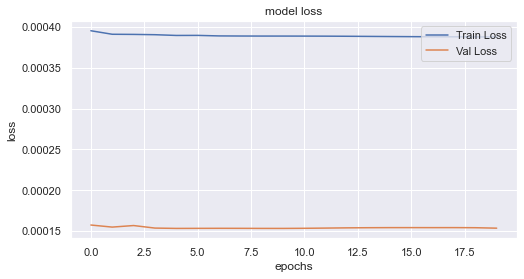

In [8]:
import matplotlib.pyplot as plt
train_score = model.evaluate(trainX, trainY, verbose=0)
print('Train Root Mean Squared Error(RMSE): %.4f; Train Mean Absolute Error(MAE) : %.4f ' 
% (np.sqrt(train_score[1]), train_score[2]))
test_score = model.evaluate(testX, testY, verbose=0)
print('Test Root Mean Squared Error(RMSE): %.4f; Test Mean Absolute Error(MAE) : %.4f ' 
% (np.sqrt(test_score[1]), test_score[2]))
model_loss(history)

In [9]:
def prediction_plot(testY, test_predict):
    len_prediction=[x for x in range(len(testY))]
    plt.figure(figsize=(8,4))
    plt.plot(len_prediction, testY[:], marker='.', label="actual")
    plt.plot(len_prediction, test_predict[:], 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Ads Daily Spend', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show();

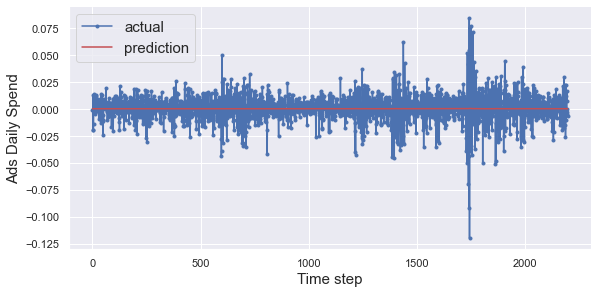

In [10]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
prediction_plot(testY, test_predict)

In [11]:
rmse = np.sqrt(mean_squared_error(testY, test_predict))
print(rmse)

0.012386971215765414
